# Monthly Dominant Policies and Policy GDP & Unemployment Impact

This notebook shows the calculation of the impact of each policy on GDP and Employment rate for every region. The notebook uses the functions in `utils/cost_utils` and more details about the calculations can be found there.

In [1]:
import numpy as np
import pandas as pd

In [2]:
import os
os.chdir("../")

In [3]:
from utils.cost_utils import *

In [4]:
start_date = "2020-03-01"
end_date =  "2020-12-31"

summary_df = None

for region in ['DE', 'US-NY', 'US-FL', 'ES', 'BR', 'SG']:
    dominant_policy_df = get_dominant_policy_df(start_date, end_date, region)
    policy_gdp_impact_df = get_policy_gdp_impact(region, dominant_policy_df)
    policy_emp_impact_df = get_policy_employment_impact(region, dominant_policy_df)
    # region_gamma_df = get_region_gamma_df(region, start_date, end_date)
    region_gamma_df = get_region_gamma_df_v2(region, start_date, end_date)
    df = pd.merge(policy_gdp_impact_df, policy_emp_impact_df.drop(columns=["gamma"]), left_index=True, right_index=True, how="left")
    df = df.join(region_gamma_df, how='left')
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'policy'}, inplace=True)
    df['region'] = region
    if summary_df is None:
        summary_df = df
    else:
        summary_df = pd.concat([summary_df, df])

Index(['region_gamma'], dtype='object')
Index(['region_gamma'], dtype='object')
Index(['region_gamma'], dtype='object')
Index(['region_gamma'], dtype='object')
Index(['region_gamma'], dtype='object')
Index(['region_gamma'], dtype='object')


In [5]:
summary_df

,policy,gamma,pred_gdp_impact,gdp_r2,pred_unemployment_gain,unemployment_r2,region_gamma,region
0,No_Measure,1.000,-0.000000,-0.226635,0.000000,-0.286755,0.152926,DE
1,Restrict_Mass_Gatherings,0.873,-1.354849,-0.226635,0.194574,-0.286755,0.133504,DE
2,Authorize_Schools_but_Restrict_Mass_Gatherings...,0.794,-2.197629,-0.226635,0.315608,-0.286755,0.055275,DE
3,Mass_Gatherings_Authorized_But_Others_Restricted,0.668,-3.541810,-0.226635,0.508649,-0.286755,0.706184,DE
4,Restrict_Mass_Gatherings_and_Schools,0.479,-5.558082,-0.226635,0.798212,-0.286755,0.073252,DE
5,Restrict_Mass_Gatherings_and_Schools_and_Others,0.423,-6.155495,-0.226635,0.884008,-0.286755,0.079276,DE
6,Lockdown,0.239,-8.118426,-0.226635,1.165910,-0.286755,0.009826,DE
0,No_Measure,1.000,-0.000000,0.780378,0.000000,0.849137,1.314137,US-NY
1,Restrict_Mass_Gatherings,0.873,-1.396260,0.780378,1.770703,0.849137,0.300695,US-NY
2,Authorize_Schools_but_Restrict_Mass_Gatherings...,0.794,-2.264799,0.780378,2.872164,0.849137,0.273484,US-NY


Save table with calculation results that is used as input data in `cost_functions/economic_cost/economic_data/economic_params.py`

In [6]:
summary_df.to_csv('simulation_results/policy_economic_impact_calculation_results_v2.csv', index=False)

## Create Dictionaries for Input Data

In [7]:
employment_impact = dict()
gdp_impact = dict()

In [8]:
for region, region_results in summary_df.groupby('region'):
    region_gdp = dict()
    region_emp = dict()
    for _, r in region_results.iterrows():
        region_gdp[r['policy']] = round(r['pred_gdp_impact'], 1)
        region_emp[r['policy']] = round(r['pred_unemployment_gain'], 1)
    
    employment_impact[region] = region_emp
    gdp_impact[region] = region_gdp

In [10]:
gdp_impact

{'BR': {'No_Measure': -0.0,
  'Restrict_Mass_Gatherings': -0.5,
  'Authorize_Schools_but_Restrict_Mass_Gatherings_and_Others': -0.8,
  'Mass_Gatherings_Authorized_But_Others_Restricted': -1.2,
  'Restrict_Mass_Gatherings_and_Schools': -1.9,
  'Restrict_Mass_Gatherings_and_Schools_and_Others': -2.1,
  'Lockdown': -2.8},
 'DE': {'No_Measure': -0.0,
  'Restrict_Mass_Gatherings': -1.4,
  'Authorize_Schools_but_Restrict_Mass_Gatherings_and_Others': -2.2,
  'Mass_Gatherings_Authorized_But_Others_Restricted': -3.5,
  'Restrict_Mass_Gatherings_and_Schools': -5.6,
  'Restrict_Mass_Gatherings_and_Schools_and_Others': -6.2,
  'Lockdown': -8.1},
 'ES': {'No_Measure': -0.0,
  'Restrict_Mass_Gatherings': -3.5,
  'Authorize_Schools_but_Restrict_Mass_Gatherings_and_Others': -5.7,
  'Mass_Gatherings_Authorized_But_Others_Restricted': -9.2,
  'Restrict_Mass_Gatherings_and_Schools': -14.4,
  'Restrict_Mass_Gatherings_and_Schools_and_Others': -16.0,
  'Lockdown': -21.1},
 'SG': {'No_Measure': -0.0,
  'Res

In [10]:
employment_impact

{'BR': {'No_Measure': 0.0,
  'Restrict_Mass_Gatherings': 0.4,
  'Authorize_Schools_but_Restrict_Mass_Gatherings_and_Others': 0.7,
  'Mass_Gatherings_Authorized_But_Others_Restricted': 1.1,
  'Restrict_Mass_Gatherings_and_Schools': 1.8,
  'Restrict_Mass_Gatherings_and_Schools_and_Others': 2.0,
  'Lockdown': 2.6},
 'DE': {'No_Measure': 0.0,
  'Restrict_Mass_Gatherings': 0.2,
  'Authorize_Schools_but_Restrict_Mass_Gatherings_and_Others': 0.3,
  'Mass_Gatherings_Authorized_But_Others_Restricted': 0.5,
  'Restrict_Mass_Gatherings_and_Schools': 0.8,
  'Restrict_Mass_Gatherings_and_Schools_and_Others': 0.9,
  'Lockdown': 1.2},
 'ES': {'No_Measure': 0.0,
  'Restrict_Mass_Gatherings': 0.5,
  'Authorize_Schools_but_Restrict_Mass_Gatherings_and_Others': 0.8,
  'Mass_Gatherings_Authorized_But_Others_Restricted': 1.2,
  'Restrict_Mass_Gatherings_and_Schools': 1.9,
  'Restrict_Mass_Gatherings_and_Schools_and_Others': 2.1,
  'Lockdown': 2.8},
 'SG': {'No_Measure': 0.0,
  'Restrict_Mass_Gatherings': 0

## Plots of Gamma Fitting

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
summary_df = pd.read_csv('simulation_results/policy_economic_impact_calculation_results.csv')

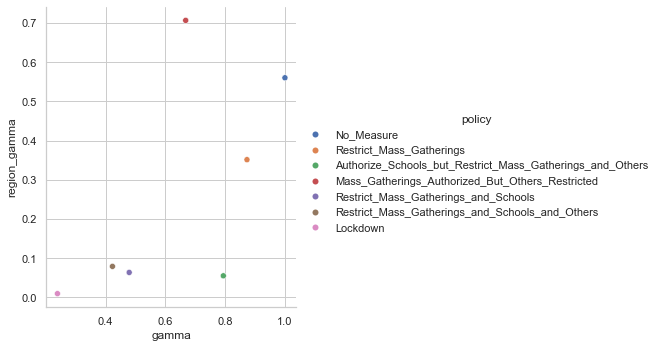

In [12]:
sns.set_theme(style='whitegrid')
sns.relplot(data=summary_df.query("region == 'DE'"), x='gamma', y='region_gamma', hue='policy')

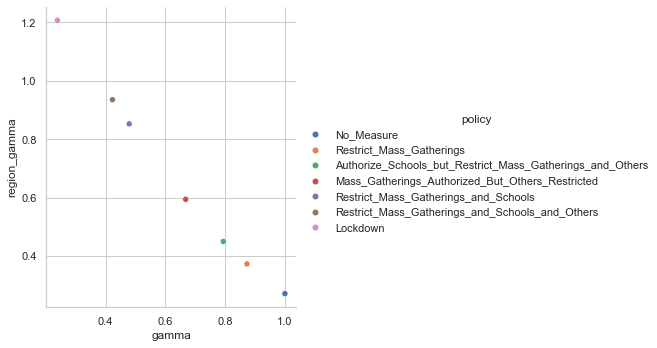

In [13]:
sns.set_theme(style='whitegrid')
sns.relplot(data=summary_df.query("region == 'BR'"), x='gamma', y='region_gamma', hue='policy')